In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on The Edge Set of a Graph (Simplicial 2-complex)
This notebook shows how to define and evaluate kernels on the edge space of a graph, i.e. kernels $k: E \times E \to \mathbb{R}$ where $E$ is the edge set of some user-provided graph $G$. 
Formally, we work with a simplicial 2-complex, which is essentially a graph $G = (V, E)$, where $V$ is the node set and $E$ is the edge set, together with a set of triangles $T$.
However, if you don't know how to set $T$, you don't need to worry, as we have a reasonable default for it, allowing you to regard this space as just a graph.

The graph $G$ **must be** unweigted, undirected, and without loops.

The edges are indexed from $1$ to $|E|$ (inclusive), i.e. $E = \{1, 2, ..., |E|\}$.
The graph is **oriented** (not to be confused with *directed*): for each $e \in E$, we have $e = (i, j)$ with $i, j \in V$, and where $(i, j)$ is an **ordered** tuple defining the positive orientation of the edge.
The edge $(j, i)$ is then considered to be negatively oriented, and is sometimes referred to as $-e$.
This is why we start indexing edges from $1$: to always be able to take $-e$.
The functions $f: E \to \mathbb{R}$ are assumed to be automatically extended to $E \cup -E$ by $f(-e) = -f(e)$.

**Note:** orientation and ordering of edges do not change the geometry of the space.
However, they affect the way in which you represent the data.

At the very end of the notebook we also show how to construct *approximate finite-dimensional feature maps* for the kernels on the edge space of graphs and how to use these to efficiently sample the Gaussian processes $\mathrm{GP}(0, k)$.

We use the **numpy** backend here.

**Important:** the goal of these kernels is to model the covariance between edges for the flow-type data, e.g., water flows, information flows.
If you want to model a **signal on the nodes** of a graph $G$, take a look into [Graph.ipynb](https://geometric-kernels.github.io/GeometricKernels/examples/Graph.html).
If you are interested in more general cellular complexes, you might want to look into [Alain et al. (2023)](https://arxiv.org/abs/2311.01198).
If you want to model a singal on a metric graph, take a look into [Bolin et al. (2023)](https://arxiv.org/abs/2304.10372).
However, the machinery from the latter two papers is not currently implemented in GeometricKernels.

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualizing Kernels](#Visualizing-Kernels)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import GraphEdges
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


### Defining a Space

First we create and visualize a simple *5-node, 6-edge graph* using `networkx`

In [3]:
nx_graph = nx.Graph()
nx_graph.add_edges_from([(0, 1), (0, 2), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])

# explicitly set node positions for visualization
pos = {0: (0, 0), 1: (-1, 0.3), 2: (2, 0.17), 3: (4, 0.255), 4: (5, 0.03)}

Visualize the graph.

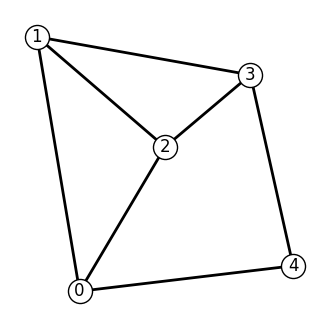

In [4]:
graph_vis_options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 2,
    "with_labels": True,    
}
plt.figure(figsize=(4,4))
nx.draw(nx_graph, ax=plt.gca(), pos=pos, **graph_vis_options)
plt.show()

The following cell turns the `nx_graph` created above into a GeometricKernels `GraphEdges` space.

For this, we use the `GraphEdges.from_adjacency` static method, which is the easiest way to do this.

**Note:** it requires a random generator `type_reference` which determines the backend to be used for the space's internal computations.
Here we use `numpy`.

In [5]:
type_reference = np.random.RandomState()  # defines the backend, never used for random number generation
# "nodelist=..." below allows us to preserve the node labels we've used to create the graph
adj_matrix = nx.to_numpy_array(nx_graph, nodelist=range(nx_graph.number_of_nodes()))

graph_edges = GraphEdges.from_adjacency(adj_matrix, type_reference, checks_mode="comprehensive")

By default, `GraphEdges.from_adjacency` assumes that all admissible triples of nodes form triangles.
A triple of nodes $(i, j, k)$ is admissible if all edges $(i, j), (j, k), (k, i)$ exist.

In the next cell, we fill the triangles in the resulting `graph_edges` space with gray.
The triangles are used to define the *curl* operator on $G$, and thus determine the Hodge decomposition.

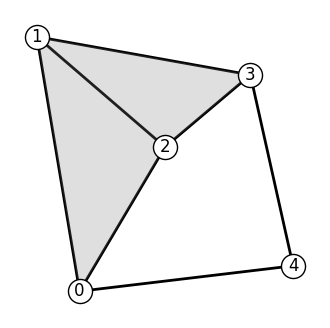

In [6]:
plt.figure(figsize=(4,4))
nx.draw(nx_graph, ax=plt.gca(), pos=pos, **graph_vis_options)

# resolve_triangles method allows to resolve a batch of triangle indices to a batch of triples of nodes.
triangles = graph_edges.resolve_triangles(np.arange(graph_edges.num_triangles))
for t in range(graph_edges.num_triangles):
    i, j, k = triangles[t, :]
    plt.fill(
        [pos[i][0], pos[j][0], pos[k][0]],
        [pos[i][1], pos[j][1], pos[k][1]],
        "gray",
        alpha=0.25
    )    
plt.show()

You can always use `resolve_edges` and `resolve_triangles` methods to determine the ordering and orientation of edges and triangles.

In [7]:
print("Edges:")
for edge_index in range(1, graph_edges.num_edges + 1):
    edge = graph_edges.resolve_edges(np.array([edge_index,])).flatten() # a bit ugly because resolve_edges is supposed to work with batches
    edge_opposite = graph_edges.resolve_edges(np.array([-edge_index,])).flatten()
    print(f"Edge index {edge_index} corresponds to the edge ({edge[0]}, {edge[1]})"
          f", while edge index {-edge_index} corresponds to the edge ({edge_opposite[0]}, {edge_opposite[1]})")

print()
print("Triangles:")
for triangle_index in range(graph_edges.num_triangles):
    triangle_edges = graph_edges.oriented_triangles[triangle_index, :]
    triangle_nodes = graph_edges.resolve_triangles(np.array([triangle_index,])).flatten() # a bit ugly because resolve_triangles is supposed to work with batches
    print(f"Triangle index {triangle_index} corresponds to"
          f" edge indices ({triangle_edges[0]}, {triangle_edges[1]}, {triangle_edges[2]})"
          f" and is composed of nodes ({triangle_nodes[0]}, {triangle_nodes[1]}, {triangle_nodes[2]})")

Edges:
Edge index 1 corresponds to the edge (0, 1), while edge index -1 corresponds to the edge (1, 0)
Edge index 2 corresponds to the edge (0, 2), while edge index -2 corresponds to the edge (2, 0)
Edge index 3 corresponds to the edge (0, 4), while edge index -3 corresponds to the edge (4, 0)
Edge index 4 corresponds to the edge (1, 2), while edge index -4 corresponds to the edge (2, 1)
Edge index 5 corresponds to the edge (1, 3), while edge index -5 corresponds to the edge (3, 1)
Edge index 6 corresponds to the edge (2, 3), while edge index -6 corresponds to the edge (3, 2)
Edge index 7 corresponds to the edge (3, 4), while edge index -7 corresponds to the edge (4, 3)

Triangles:
Triangle index 0 corresponds to edge indices (1, 4, -2) and is composed of nodes (0, 1, 2)
Triangle index 1 corresponds to edge indices (4, 6, -5) and is composed of nodes (1, 2, 3)


#### Manually Defining the Set of Triangles

You can also manually define the triangles and provide them as an optional argument to the `GraphEdges.from_adjacency` method.

They should be represented by a list of triples of node indices, like below.
Note, that all triples $(i, j, k)$ must still be adissible, i.e. all edges $(i, j), (j, k), (k, i)$ must exist.

In [8]:
triangles = [(0,1,2)]
graph_edges = GraphEdges.from_adjacency(adj_matrix, type_reference, triangles=triangles, checks_mode="comprehensive")

Now, if we visualize the space, it will look differently. (Notice that the triangle composed of nodes (1, 2, 3) is now missing)

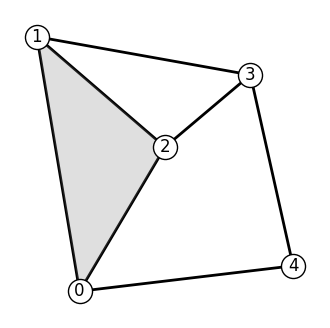

In [9]:
plt.figure(figsize=(4,4))
nx.draw(nx_graph, ax=plt.gca(), pos=pos, **graph_vis_options)

# resolve_triangles method allows to resolve a batch of triangle indices to a batch of triples of nodes.
triangles = graph_edges.resolve_triangles(np.arange(graph_edges.num_triangles))
for t in range(graph_edges.num_triangles):
    i, j, k = triangles[t, :]
    plt.fill(
        [pos[i][0], pos[j][0], pos[k][0]],
        [pos[i][1], pos[j][1], pos[k][1]],
        "gray",
        alpha=0.25
    )    
plt.show()

In [10]:
print("Triangles:")
for triangle_index in range(graph_edges.num_triangles):
    triangle_edges = graph_edges.oriented_triangles[triangle_index, :]
    triangle_nodes = graph_edges.resolve_triangles(np.array([triangle_index,])).flatten() # a bit ugly because resolve_triangles is supposed to work with batches
    print(f"Triangle index {triangle_index} corresponds to"
          f" edge indices ({triangle_edges[0]}, {triangle_edges[1]}, {triangle_edges[2]})"
          f" and is composed of nodes ({triangle_nodes[0]}, {triangle_nodes[1]}, {triangle_nodes[2]})")

Triangles:
Triangle index 0 corresponds to edge indices (1, 4, -2) and is composed of nodes (0, 1, 2)


### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `sc` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on graphs can be found on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/graphs.html).
For graph edges specifically, the *Hodge decomposition* plays a key role, which is briefly discussed on the same documentation page.

Define a Hodge-compositional kernel by setting 'use_hodge_composition' to True; otherwise, the kernel is a Matérn kernel which does not differentiate the different Hodge subspace.

In [11]:
kernel = MaternGeometricKernel(graph_edges)

check the eigenbasis and their types being either gradient, curl or harmonic

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.
An example of this can be found in [frontends/GPyTorch.ipynb](https://geometric-kernels.github.io/GeometricKernels/examples/frontends/GPyTorch.html), where we use `gpytorch.kernels.ScaleKernel` for this.

In [12]:
params = kernel.init_params()
print('params:', params)

params: {'harmonic': {'logit': array([1.]), 'nu': array([inf]), 'lengthscale': array([1.])}, 'gradient': {'logit': array([1.]), 'nu': array([inf]), 'lengthscale': array([1.])}, 'curl': {'logit': array([1.]), 'nu': array([inf]), 'lengthscale': array([1.])}}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params` we define below.

**Note:** unlike the Euclidean or the manifold case, the $1/2, 3/2, 5/2$ may fail to be the reasonable values of $\nu$.
On the other hand, the parameter $\nu$ is optimizable in the same way in which the legnthscale is.
Keep in mind though, that the optimization problem may require finding some trial and error to find good a initialization and that reasonable $\kappa$ and $\nu$ will heavily depend on the specific graph in a way that is hard to predict.


**Note**: for the Hodge-compositional kernel, we need to specify the parameters for each Hodge subspace. 

In [13]:
params["harmonic"]["lengthscale"] = np.array([0.5])
params["gradient"]["lengthscale"] = np.array([2.0])
params["curl"]["lengthscale"] = np.array([1.0])

params_hodge_1 = params.copy()
params_hodge_2 = params.copy()
del params

params_hodge_1["harmonic"]["nu"], params_hodge_1["gradient"]["nu"], params_hodge_1["curl"]["nu"] = np.array([3/2]), np.array([3/2]), np.array([3/2])
params_hodge_2["harmonic"]["nu"], params_hodge_2["gradient"]["nu"], params_hodge_2["curl"]["nu"] = np.array([np.inf]), np.array([np.inf]), np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs (i.e., edges).

### Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [14]:
key = np.random.RandomState(1234)

key, xs = graph_edges.random(key, 3)

print("xs:")
print(xs)

print("")

print("The edge indices in xs correspond to the following edges:")
print(graph_edges.resolve_edges(xs.squeeze()))

xs:
[[4]
 [7]
 [6]]

The edge indices in xs correspond to the following edges:
[[1 2]
 [3 4]
 [2 3]]


In the following cell, we highlight the sampled edges in green.

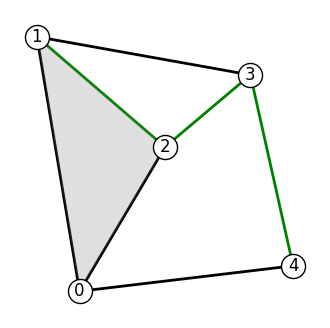

In [15]:
sampled_edges_nx = set()
for u, v in graph_edges.resolve_edges(xs.squeeze()):
    sampled_edges_nx.update([(u, v), (v, u)])
edge_color = ['green' if x in sampled_edges_nx else 'black' for x in nx_graph.edges]

plt.figure(figsize=(4,4))
nx.draw(nx_graph, ax=plt.gca(), pos=pos, **graph_vis_options, edge_color=edge_color)

# resolve_triangles method allows to resolve a batch of triangle indices to a batch of triples of nodes.
triangles = graph_edges.resolve_triangles(np.arange(graph_edges.num_triangles))
for t in range(graph_edges.num_triangles):
    i, j, k = triangles[t, :]
    plt.fill(
        [pos[i][0], pos[j][0], pos[k][0]],
        [pos[i][1], pos[j][1], pos[k][1]],
        "gray",
        alpha=0.25
    )    
plt.show()

Now we evaluate the two kernel matrices.

In [16]:
kernel_mat_32 = kernel.K(params_hodge_1, xs, xs)
kernel_mat_inf = kernel.K(params_hodge_2, xs, xs)

Finally, we visualize these matrices using `imshow`.

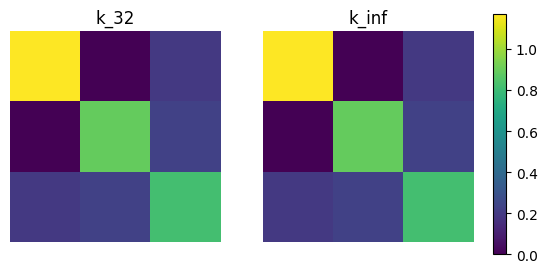

In [17]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualizing Kernels

Here we visualize $k_{\nu, \kappa}($ `base_edge` $, x)$ for $x \in $ `other_edges`.
We define `base_edge` and `other_edges` in the next cell.

In [18]:
base_edge_idx = 1
print(f"base_edge_idx={base_edge_idx} corresponds to the edge {graph_edges.resolve_edges(np.array([base_edge_idx])).flatten()}")
other_edges_idx = np.arange(1, graph_edges.num_edges + 1)[:, None]

base_edge_idx=1 corresponds to the edge [0 1]


The next cell evaluates $k_{\nu, \kappa}($ `base_edge` $, x)$ for $x \in $ `other_edges` for $\nu$ either $3/2$ or $\infty$.

In [19]:
values_32  = kernel.K(params_hodge_1, np.array([[base_edge_idx]]), other_edges_idx).flatten()
values_inf = kernel.K(params_hodge_2, np.array([[base_edge_idx]]), other_edges_idx).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_edges` for $\nu$ either $3/2$ or $\infty$.

In [20]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_hodge_1, other_edges_idx)
variance_inf = kernel.K_diag(params_hodge_2, other_edges_idx)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_edge, *)` where `*` goes through all nodes and `base_edge` has red outline. 

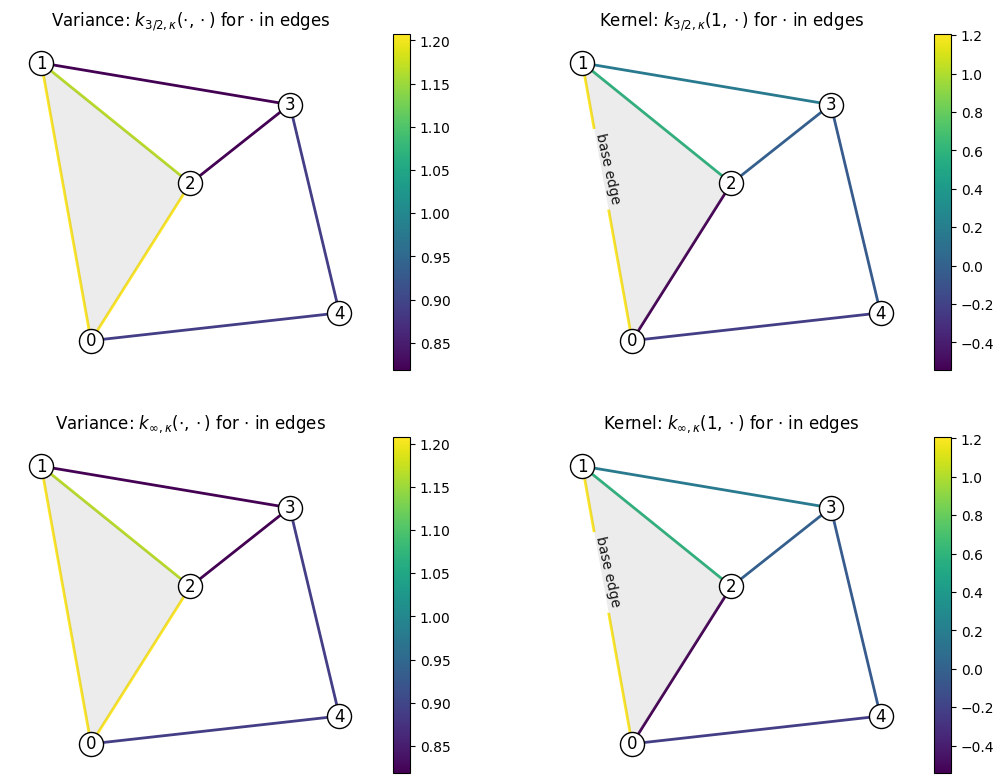

In [21]:
cmap = plt.get_cmap('viridis')
edges = [e for e in nx_graph.edges()]

# Set the colorbar limits:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(nx_graph, pos=pos, ax=ax1, edge_cmap=cmap, edge_color=np.array(variance_32),
        edge_vmin=variance_32.min(), edge_vmax=values_32.max(),  **graph_vis_options)
# shade the area of the triangle
ax1.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=variance_32.min(), vmax=variance_32.max()))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: $k_{3/2, \kappa}(\cdot, \cdot)$ for $\cdot$ in edges')

# Plot kernel values 32
nx.draw(nx_graph, pos=pos, ax=ax2, edge_cmap=cmap, edge_color=np.array(values_32),
        edge_vmin=values_32.min(), edge_vmax=values_32.max(), **graph_vis_options)
# add a label at the base edge 
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={(edges[base_edge_idx-1][0], edges[base_edge_idx-1][1]): 'base edge'}, verticalalignment='baseline', ax=ax2)
ax2.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=values_32.min(), vmax=values_32.max()))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in edges' % base_edge_idx)


# Plot variance inf
nx.draw(nx_graph, pos=pos, ax=ax3, edge_cmap=cmap, edge_color=np.array(variance_inf),
        edge_vmin=variance_inf.min(), edge_vmax=variance_inf.max(), **graph_vis_options)
ax3.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=variance_inf.min(), vmax=variance_inf.max()))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: $k_{\infty, \kappa}(\cdot, \cdot)$ for $\cdot$ in edges')

# Plot kernel values inf
nx.draw(nx_graph, pos=pos, ax=ax4, edge_cmap=cmap, edge_color=np.array(values_inf),
        edge_vmin=values_inf.min(), edge_vmax=values_inf.max(),
         **graph_vis_options)
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={(edges[base_edge_idx-1][0], edges[base_edge_idx-1][1]): 'base edge'}, verticalalignment='baseline', ax=ax4)
ax4.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=values_inf.min(), vmax=values_inf.max()))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in edges' % base_edge_idx)


plt.show()

**Note:** variance changes from edge to edge, this is normal behavior.

In [22]:
print('Variance in the edge (%d,%d) is %0.2f,' % (edges[0][0], edges[0][1], variance_32[0]))
print('Variance in the edge (%d,%d) is %0.2f,' % (edges[1][0], edges[1][1], variance_32[1]))
print('The average variance is %0.2f.' % np.mean(variance_32))

Variance in the edge (0,1) is 1.21,
Variance in the edge (0,2) is 1.21,
The average variance is 1.00.


## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on graphs, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [23]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the edge sapce of graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `GraphEdge` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [24]:
print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')

# xs are random points from above
_, embedding = feature_map(xs, params_hodge_1)
kernel_mat_32  = kernel.K(params_hodge_1,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))
    
print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (3, 1)):
[[4]
 [7]
 [6]]

emedding (shape = (3, 7)):
[[-3.71833679e-01 -2.37031980e-01  8.81917104e-01  4.85467264e-16
  -3.06078844e-16 -4.41934324e-01  5.38535320e-17]
 [-3.35213842e-01  5.25852231e-01  0.00000000e+00  5.94921063e-01
   3.27620242e-01 -3.65194704e-16 -1.98711721e-01]
 [-7.25357439e-01 -9.26218550e-02  0.00000000e+00  2.97460531e-01
  -3.27620242e-01  2.20967162e-01  1.98711721e-01]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 3.178777788932899e-16


### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [25]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_hodge_1, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[-1.21678079  0.37588116]
 [ 1.13606525 -0.30789406]
 [-0.04717773  1.58900573]]


#### Visualizing Samples
Here we visualize samples as functions on the edges of a graph.

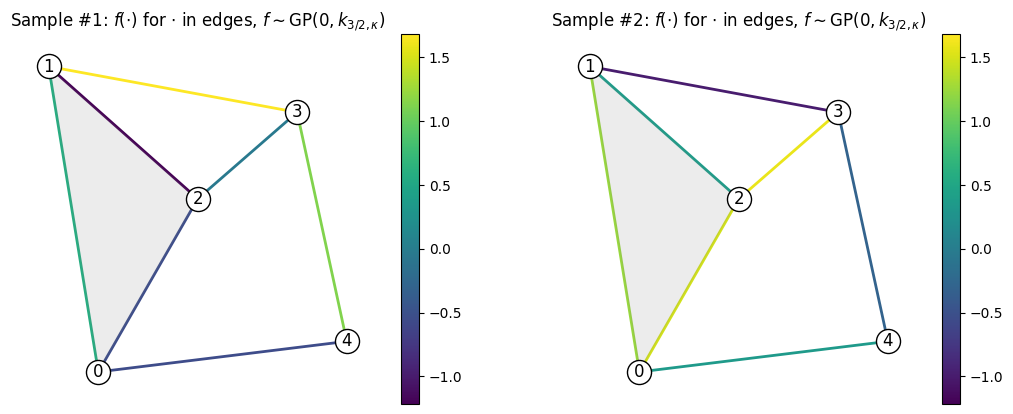

In [26]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_edges_idx, params_hodge_1, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())
 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(nx_graph, pos=pos, ax=ax1, edge_cmap=cmap, edge_color=sample1,
        edge_vmin=vmin, edge_vmax=vmax, **graph_vis_options)
ax1.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in edges, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(nx_graph, pos=pos, ax=ax2, edge_cmap=cmap, edge_color=sample2,
        edge_vmin=vmin, edge_vmax=vmax, **graph_vis_options)
ax2.fill([0, -1, 2], [0, 0.3, 0.17], "gray", alpha=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in edges, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

## Citation

If you are using graphs and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@inproceedings{yang2024,
      title = {Hodge-Compositional Edge Gaussian Processes},
      author = {Yang, Maosheng and Borovitskiy, Viacheslav and Isufi, Elvin},
      booktitle={International Conference on Artificial Intelligence and Statistics},
      year = {2024},
}
```